In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
np.set_printoptions(suppress = True)

In [3]:
df=pd.read_excel('/content/drive/MyDrive/Data.xlsx')
X=df.iloc[:,0:3]
y=df.iloc[:,3]
X=X.to_numpy()
y=y.to_numpy()
y=y.reshape((-1,1))

# **First Order Optimizers**

## Gradient Descent

In [4]:
import seaborn as sns
from abc import ABC, abstractmethod
import numpy as np
class Gradient_descent:
  """
  A parent abstract class for all first order optimizers
  Parameters
  ------------
  Learning rate : used to control the step taken by the gradient.
  gamma : the paramter to be adjusted to use momentum GD , default is zero which is vanilla GD.
  max iterations : to stop when reached.
  gradient_tolerance: stop when gradient norm reaches this value.
  cost_tolerance: cost difference between two iterations reaches this value.
  batch_size: default=None, enter 1 for stochastic GD of any batch size.
  """

  def __init__(self,Learning_rate=0.00001,gamma=0,max_iterations=1000,gradient_tolerance=0.01,cost_tolerance=0.1,batch_size=None):##instance variables
    # Learning rate is used to control the step taken by the gradient
    self.Learning_rate=Learning_rate
    #gamma is the paramter to be adjusted to use momentum GD , default is zero which is vanilla GD
    self.gamma=gamma
    #max iterations to stop when reached
    self.max_iterations=max_iterations
    #stop when gradient norm reaches this value
    self.gradient_tolerance=gradient_tolerance
    #stop when cost difference between two iterations reaches this value
    self.cost_tolerance=cost_tolerance
    # default is batch GD , enter 1 for stochastic or any value preferable 2power (n) for mini batch
    self.batch_size=batch_size
    # not to stop in the first iteration when calculating cost difference
    self.J_temp=float('inf')
    # An empty array to store cost value per iteration
    self.Cost_arr2 = np.array([])
    # An empty array to store thetas
    self.theta_history = np.array([])
    #learning rate should be float or integer
    if Learning_rate>0 and Learning_rate<=1 :
      pass
    else:
      raise ValueError("Learning_rate should be a number greater than 0 and less than or equal 1")

    #Gamma should be float or integer

    if gamma>=0 and gamma<=1 :
      pass
    else:
      raise ValueError("gamma should be a number between 0 and 1 inclusively")
    #gradient_tolerance should be float or integer
    if gradient_tolerance<=0:
      raise ValueError("gradient_tolerance should be a number greater than zero")
    #cost_tolerance should be float or integer
    if cost_tolerance<=0:
      raise ValueError("cost_tolerance should be a number greater than zero")
    if type(max_iterations)!=int or max_iterations<0:
      raise ValueError("max_iterations should be a positive integer")
    #raise value error if batch size isn't integer
    if batch_size is  None :
      pass
    elif type(batch_size)==int and batch_size>0:
      pass
    else:
      raise ValueError("Batch size can't be negative or float")
  def plot_thetas(self,style="white",marker="X",grid=True):
    """
    Returns number of plots equal to model parameters , each model parameter versus loss.
    Paramters:
    style: String indicating the style of the plot default="white", can be White, Dark, Whitegrid, Ticks, Darkgrid.
    marker: String representing the style of points in the graph defaul="X",can be ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X',0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'None', None, ' ', ''].
    grid: Boolean indicating whether to add grid or not , default=True.
    """
    sns.set(style=style)
    for i in range(self.theta_history.shape[1]):
      plt.plot(self.theta_history[:,i],self.Cost_arr2,marker=marker)
      plt.xlabel(f"Theta{i}")
      plt.ylabel("Loss")
      if grid==True:
        plt.grid()
      plt.title(f"Theta{i} vs Loss")
      plt.show();

  # a private function to shuffle the data if stochastic or mini batch is applied
  def _shuffle(self,input_data,target_variable):
    self.input_data=input_data
    self.target_variable=target_variable
    # if batch size is set to None(default) then set the batch size to length of the data
    if self.batch_size is None:
      self.batch_size = len(self.target_variable)
    else:
      # shuffle data in case of stochastic and mini batch GD
      # we need to shuffle both X's and y together
      self.input_data = np.concatenate((self.input_data, self.target_variable), axis=1)
      self.input_data = pd.DataFrame(self.input_data)
      self.input_data = self.input_data.sample(frac=1, axis='index')
      self.input_data = self.input_data.to_numpy()
      self.target_variable = self.input_data[:, -1]
      self.target_variable = self.target_variable.reshape((-1, 1))
      self.input_data = self.input_data[:, :-1]

    return self.batch_size,self.target_variable,self.input_data
    #public method to predict y
  def predict(self,input_data):
    """
    Return a vector of predicted values for the given data.
    Parameters:
    input_data: a 2D numpy array of shape(no. of data points,no. of columns)
    """
    self.h_x = input_data @ self.thetas
    return self.h_x
  @abstractmethod
  def _update_params(self,v,sample):
    pass
  def fit(self,input_data,target_variable):
    #i is used to determine number of epochs
    self.i = 0

    self.input_data=input_data
    self.target_variable=target_variable
    # Add ones which is the column for the itercept(bias term)
    ones = np.ones(shape=(len(self.target_variable), 1))
    self.input_data = np.append(ones, self.input_data, axis=1)
    #initialize both thetas and v to zeros
    self.thetas = np.zeros(shape=(np.shape(self.input_data)[1], 1))
    v=np.zeros(shape=(np.shape(self.input_data)[1], 1))
    m=np.zeros(shape=(np.shape(self.input_data)[1], 1))
    self.batch_size,self.target_variable,self.input_data=self._shuffle(self.input_data,self.target_variable)

    while True:
        #first: calculate the predicted values and error based on whole data
        self.h_x = self.predict(self.input_data)
        self.Error_vector = self.h_x - self.target_variable

        self.J = (1 / (2 * len(self.target_variable))) * (np.linalg.norm(self.Error_vector, 2)) ** 2
        #here we calculate the gradient from the whole data for the convergence check so we divide by n
        self.Gradient_vector = np.array((1 / len(self.target_variable)) * (self.input_data.T @ self.Error_vector))
        self.Gradient_vector_Norm = np.linalg.norm(self.Gradient_vector, 2)
        self.Cost_difference = abs(self.J_temp - self.J)
        self.J_temp = self.J
        #add the cost to the cost array
        self.Cost_arr2 = np.append(self.Cost_arr2, [self.J])
        # add thetas to the theta history
        self.theta_history = np.append(self.theta_history, self.thetas.flatten())
        #Convergence check,We check convergence per epoch based on whole data not mini batch
        if self.i == self.max_iterations:
          print('Reached maximum iterations')
          break
        if self.Gradient_vector_Norm <= self.gradient_tolerance:
          print('Reached desired gradient tolerance level')
          break
        if self.Cost_difference <= self.cost_tolerance:
          print('Reached desired gradient tolerance level')
          break
        for sample in range(0, len(self.target_variable), self.batch_size):
            self.thetas=self._update_params(v,sample)
            self.i = self.i + 1
    #set thetas history to be any number of rows and number of columns = number of thetas
    self.num_thetas = np.shape(self.input_data)[1]
    self.theta_history = self.theta_history.reshape((-1, self.num_thetas))
    #first element in theta history is removed as it's the initial thetas which are set to zeros
    self.theta_history = self.theta_history[1:, :]

    self.Cost_arr2 = self.Cost_arr2.reshape((-1, 1))
    #first cost element in cost arr2 is removed as it's calculated from the initial thetas (zeros)
    self.Cost_arr2 = self.Cost_arr2[1:, 0]
    print("####################################### Training Report ###################################")
    print("Gradient Descent converged after ", self.i, "epochs")
    print("Thetas :\n ", self.thetas)
    print("#"*50)
    print("Cost = ", self.J)
    print("Final Cost difference = ", self.Cost_difference)
    return self.thetas, self.Cost_arr2, self.theta_history, self.h_x, self.target_variable
  @abstractmethod
  def plot_iterations(self,style="white",marker="X",grid=True):
    pass


## Vanilla Gradient Descent and Momentum Gradient Descent

Given:
- `J(θ)` is the cost function to minimize.
- `θ` is the parameter vector.
- `α` is the learning rate.
- `∇J(θ)` is the gradient of the cost function with respect to `θ`.
- max_iterations is the maximum number of iterations.
- cost_tolerance is the threshold for the change in the cost function.
- gradient_tolerance is the threshold for the change in the gradient.

The gradient descent algorithm with convergence checks is as follows:

1. Initialize `θ` with zeros.
2. Initialize iteration counter: iter = 0.
3. Repeat until convergence or max_iterations reached:
    - <font color="blue"> `Update θ: θ := θ - α * ∇J(θ)`</font>
   - Increment iteration counter: iter = iter + 1.
   - Compute the change in the cost function: <font color="blue"> `delta_cost = |J(θ_new) - J(θ_old)|` </font>.
   - Check convergence:
     - If delta_cost < cost_tolerance, exit loop (converged).
     - If change in gradient < gradient_tolerance, exit loop (converged).
     - If iter >= max_iterations, exit loop (maximum iterations reached).
  Same for momenum, in addition to the parameter:
  -v which is the velocity
   - Update the velocity: <font color="blue"> `v := β * v + (1 - β) * ∇J(θ)` </font>.
   - Update θ: <font color="blue"> `θ := θ - α * v` </font>.



In [5]:
class GD_Momentum(Gradient_descent):
    """
    A class inherting from Gradient_descent used to implement both vanila GD and momentum GD
    Parameters
    ------------
    Learning rate : used to control the step taken by the gradient.
    gamma : the paramter to be adjusted to use momentum GD , default is zero which is vanilla GD.
    max iterations : to stop when reached.
    gradient_tolerance: stop when gradient norm reaches this value.
    cost_tolerance: cost difference between two iterations reaches this value.
    batch_size: default=None, enter 1 for stochastic GD of any batch size.
    """
    def __init__(self, Learning_rate=0.00001, gamma=0, max_iterations=1000, gradient_tolerance=0.01, cost_tolerance=0.1, batch_size=None):
        super().__init__(Learning_rate=Learning_rate, gamma=gamma, max_iterations=max_iterations, gradient_tolerance=gradient_tolerance, cost_tolerance=cost_tolerance, batch_size=batch_size)
    def _update_params(self, v, sample):
      self.h_x=self.predict(self.input_data[sample:sample+self.batch_size, :])
      self.Error_vector=self.h_x - self.target_variable[sample:sample+self.batch_size]
      self.Gradient_vector = np.array((1 / len(self.input_data[sample:sample+self.batch_size, :])) * (self.input_data[sample:sample+self.batch_size].T @ self.Error_vector))
      v=self.gamma*v+self.Learning_rate*self.Gradient_vector
      self.thetas=self.thetas-v
      return self.thetas
    def plot_iterations(self,style="white",marker="X",grid=True):
      """
      Returns a plot of loss versus iteration number
      Parameters:
      -------------
      style: String indicating the style of the plot default="white", can be White, Dark, Whitegrid, Ticks, Darkgrid.
      marker: String representing the style of points in the graph defaul="X",can be ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X',0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'None', None, ' ', ''].
      grid: Boolean indicating whether to add grid or not , default=True.
      """
      sns.set(style=style)
      plt.plot(Cost_arr2,marker=marker)
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      if self.gamma!=0:
        plt.title(f"Learning rate = {self.Learning_rate} & gamma = {self.gamma}")
      else:
        plt.title(f"Learning rate = {self.Learning_rate}")
      if grid==True:
        plt.grid()

In [6]:
gd=GD_Momentum()
thetas, Cost_arr2, theta_history, h_x, target_variable=gd.fit(X,y)

Reached maximum iterations
####################################### Training Report ###################################
Gradient Descent converged after  1000 epochs
Thetas :
  [[ 0.1582198 ]
 [ 2.82900613]
 [ 8.53449443]
 [-3.47949776]]
##################################################
Cost =  447.5950897539834
Final Cost difference =  0.7992724801076179


In [7]:
r2_score(h_x,target_variable)

0.9505878777994837

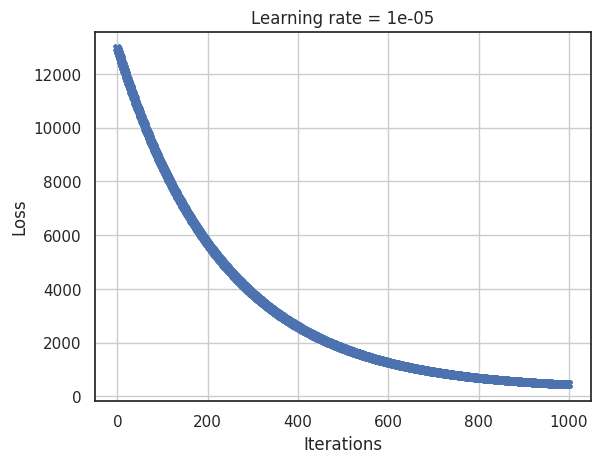

In [8]:
gd.plot_iterations()

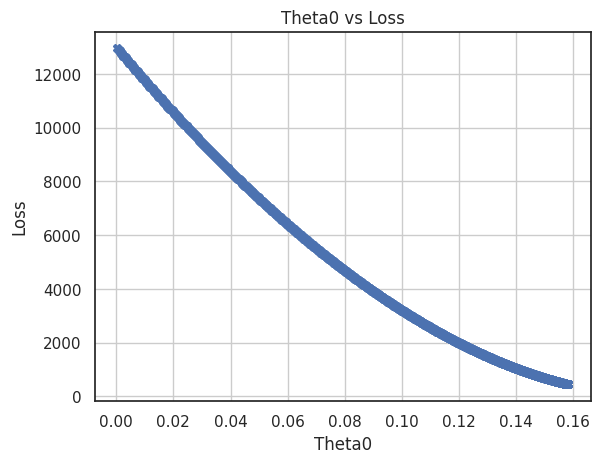

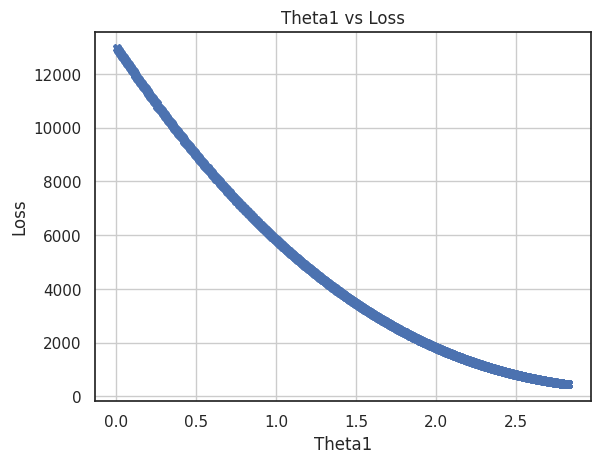

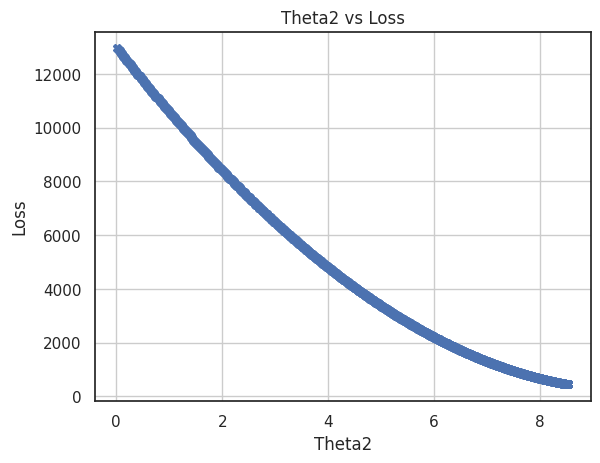

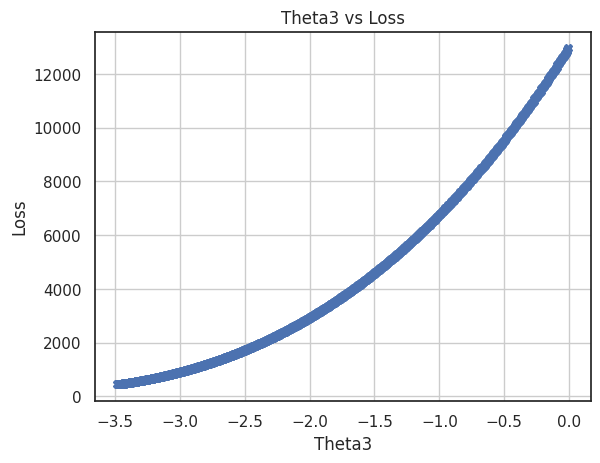

In [9]:
gd.plot_thetas()

## Nag Gradient Descent

   - Compute the gradient ahead of the current <font color="blue"> `θ: ∇J(θ - β * v)` </font>.
   - Update the velocity: <font color="blue"> `v := β * v + α * ∇J(θ - β * v)` </font>.
   - Update θ: <font color="blue"> `θ := θ - v` </font>.

In [10]:
class Nag(Gradient_descent):
    """
    A class inherting from Gradient_descent used to implement both  NAG
    Parameters
    ------------
    Learning rate : used to control the step taken by the gradient.
    gamma : the paramter to be adjusted to use momentum GD , default is zero which is vanilla GD.
    max iterations : to stop when reached.
    gradient_tolerance: stop when gradient norm reaches this value.
    cost_tolerance: cost difference between two iterations reaches this value.
    batch_size: default=None, enter 1 for stochastic GD of any batch size.
    """
    def __init__(self, Learning_rate=0.00001, gamma=0, max_iterations=1000, gradient_tolerance=0.01, cost_tolerance=0.1, batch_size=None):
        super().__init__(Learning_rate=Learning_rate, gamma=gamma, max_iterations=max_iterations, gradient_tolerance=gradient_tolerance, cost_tolerance=cost_tolerance, batch_size=batch_size)
    def _update_params(self, v, sample):
      self.h_x_temp = self.predict(self.input_data[sample:sample + self.batch_size, :] )
      self.Error_vector_temp = self.h_x_temp - self.target_variable[sample:sample + self.batch_size]
      self.Gradient_vector_temp = np.array((1 / self.batch_size) * (self.input_data[sample:sample + self.batch_size].T @ self.Error_vector_temp))
      v = self.gamma * v + self.Learning_rate * self.Gradient_vector_temp
      self.thetas = self.thetas - v
      return self.thetas
    def plot_iterations(self,style="white",marker="X",grid=True):
      """
      Returns a plot of loss versus iteration number
      Parameters:
      -------------
      style: String indicating the style of the plot default="white", can be White, Dark, Whitegrid, Ticks, Darkgrid.
      marker: String representing the style of points in the graph defaul="X",can be ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X',0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'None', None, ' ', ''].
      grid: Boolean indicating whether to add grid or not , default=True.
      """
      sns.set(style=style)
      plt.plot(Cost_arr2,marker=marker)
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      if self.gamma!=0:
        plt.title(f"Learning rate = {self.Learning_rate} & gamma = {self.gamma}")
      else:
        plt.title(f"Learning rate = {self.Learning_rate}")
      if grid==True:
        plt.grid()



In [11]:
Nag_gd=Nag(max_iterations=2000,gamma=0.9,batch_size=32)
thetas, Cost_arr2, theta_history, h_x, target_variable=Nag_gd.fit(X,y)

Reached maximum iterations
####################################### Training Report ###################################
Gradient Descent converged after  2000 epochs
Thetas :
  [[ 0.16407792]
 [ 3.18466836]
 [ 9.29719926]
 [-3.89171552]]
##################################################
Cost =  274.2445438908663
Final Cost difference =  0.24302388180620937


In [12]:
r2_score(h_x,target_variable)


0.9747942169629096

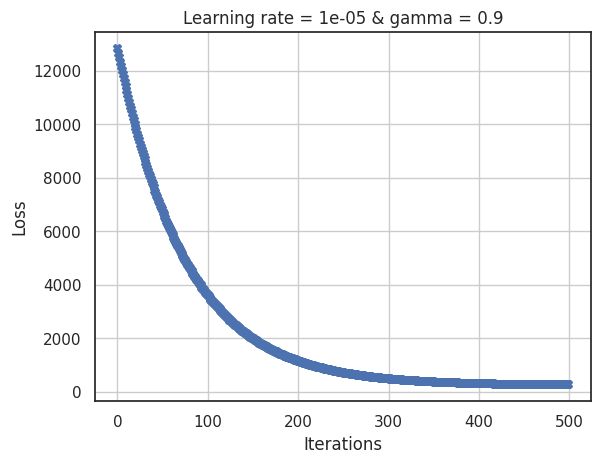

In [13]:
Nag_gd.plot_iterations()

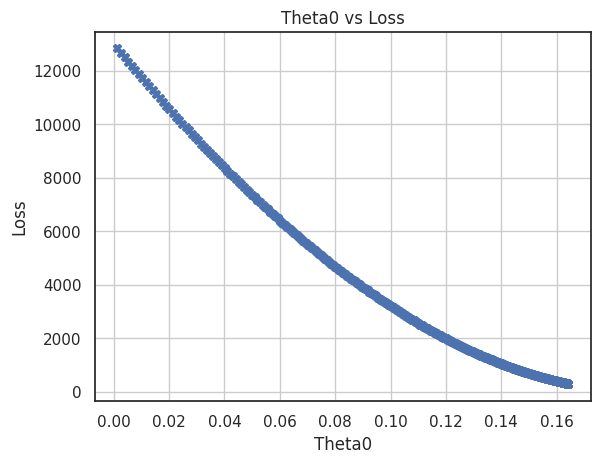

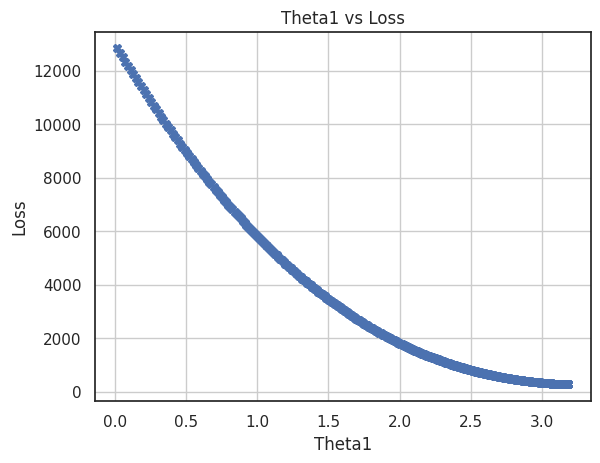

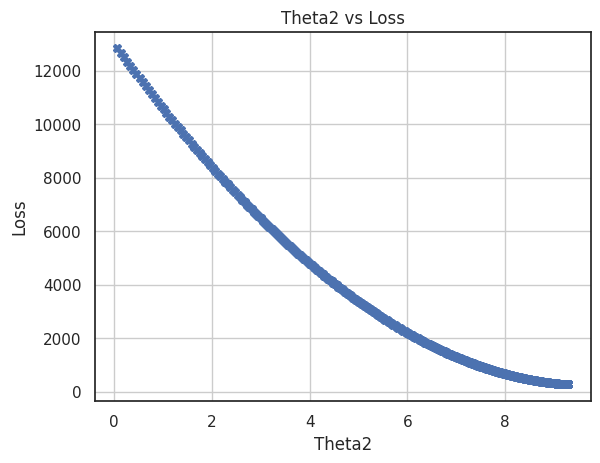

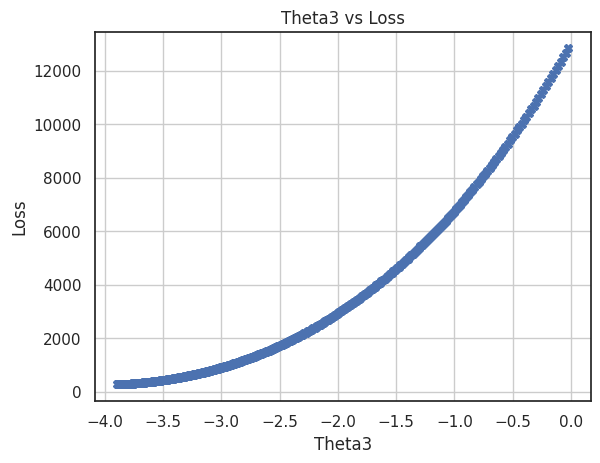

In [14]:
Nag_gd.plot_thetas()

## Adgrad and RMS Prop

   - Update the exponentially weighted moving average of squared gradients:
     <font color="blue"> `E[vt] := β * E[vt] + (1 - β) * (∇J(θ))^2` </font>.
   - Update θ: <font color="blue">`θ := θ - α * (∇J(θ) / (√(vt) + ε))`</font>.
    - if   <font color="blue"> `β=0`</font> then it reduces to Adagrad

In [15]:
class Adagrad_RMS(Gradient_descent):
    """
    A class inherting from Gradient_descent used to implement both Adagrad and RMSProp
    Parameters
    ------------
    Learning rate : used to control the step taken by the gradient.
    beta : the paramter to be adjusted to use RMSProp , default is zero which is Adagrad , it's used as the parameter of the exponentially weighted moving average of gradients.
    max iterations : to stop when reached.
    gradient_tolerance: stop when gradient norm reaches this value.
    cost_tolerance: cost difference between two iterations reaches this value.
    batch_size: default=None, enter 1 for stochastic GD of any batch size.
    """
    def __init__(self,Learning_rate=0.00001,beta=0, max_iterations=1000, gradient_tolerance=0.01, cost_tolerance=0.1, batch_size=None):
        super().__init__(Learning_rate=Learning_rate, max_iterations=max_iterations, gradient_tolerance=gradient_tolerance, cost_tolerance=cost_tolerance, batch_size=batch_size)
        self.beta=beta
    def _update_params(self, v, sample):
      self.h_x=self.predict(self.input_data[sample:sample+self.batch_size, :])
      self.Error_vector=self.h_x - self.target_variable[sample:sample+self.batch_size]
      self.Gradient_vector = np.array((1 / len(self.input_data[sample:sample+self.batch_size, :])) * (self.input_data[sample:sample+self.batch_size].T @ self.Error_vector))
      v=(self.beta)*v+(1-self.beta)*np.square(self.Gradient_vector)
      self.thetas=self.thetas-(self.Learning_rate/(np.sqrt(v)+0.0001))*self.Gradient_vector
      return self.thetas
    def plot_iterations(self,style="white",marker="X",grid=True):
      """
      Returns a plot of loss versus iteration number
      Parameters:
      -------------
      style: String indicating the style of the plot default="white", can be White, Dark, Whitegrid, Ticks, Darkgrid.
      marker: String representing the style of points in the graph defaul="X",can be ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X',0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'None', None, ' ', ''].
      grid: Boolean indicating whether to add grid or not , default=True.
      """
      sns.set(style=style)
      plt.plot(Cost_arr2,marker=marker)
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      if self.beta!=0:
        plt.title(f"Learning rate = {self.Learning_rate} & beta = {self.beta}")
      else:
        plt.title(f"Learning rate = {self.Learning_rate}")
      if grid==True:
        plt.grid()

In [16]:
Adagrad=Adagrad_RMS(Learning_rate=0.001,max_iterations=10000)
thetas, Cost_arr2, theta_history, h_x, target_variable=Adagrad.fit(X,y)

Reached desired gradient tolerance level
####################################### Training Report ###################################
Gradient Descent converged after  9092 epochs
Thetas :
  [[ 6.62796106]
 [ 3.26870996]
 [ 9.09199865]
 [-4.08938439]]
##################################################
Cost =  302.61350368070345
Final Cost difference =  0.09990688383584256


In [17]:
r2_score(h_x,target_variable)


0.9717966998557883

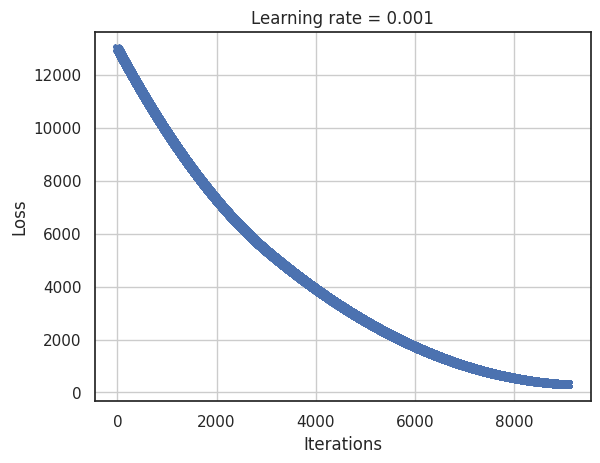

In [18]:
Adagrad.plot_iterations()

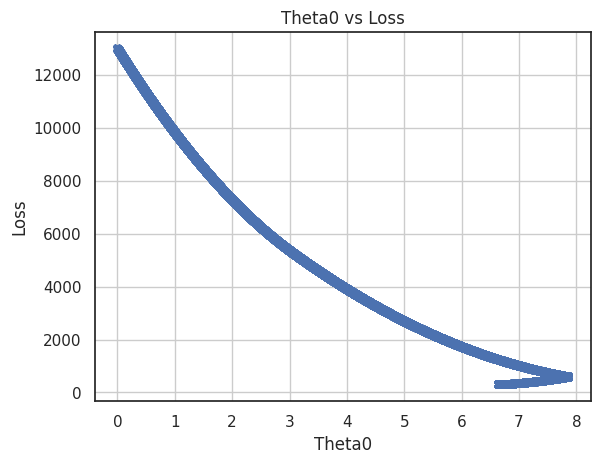

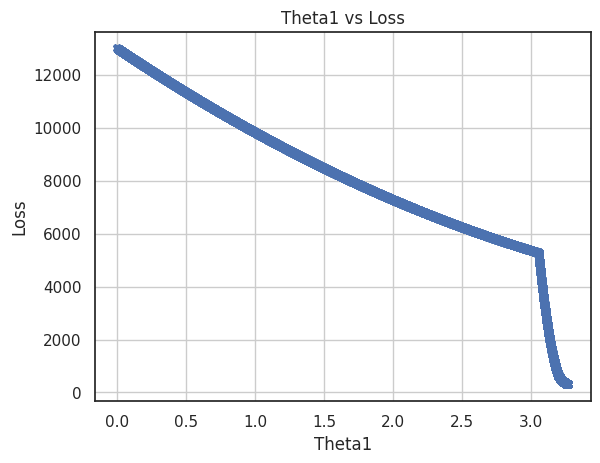

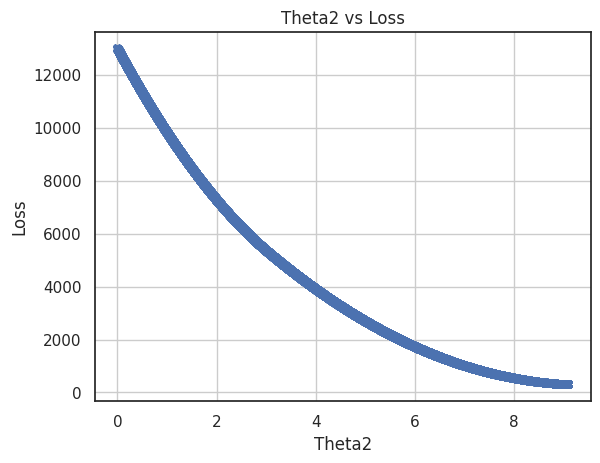

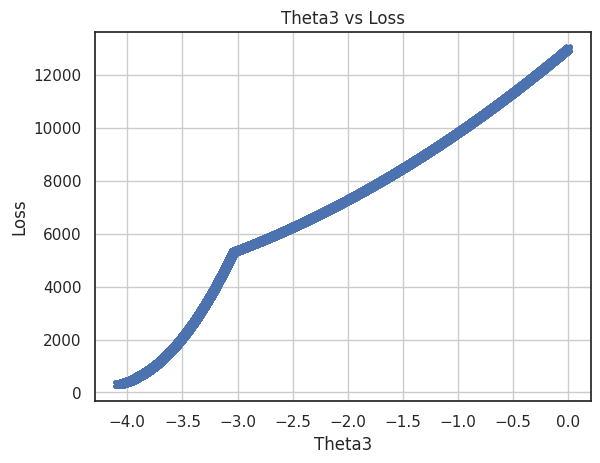

In [19]:
Adagrad.plot_thetas()

In [20]:
RMS=Adagrad_RMS(Learning_rate=0.01,beta=0.1)
thetas, Cost_arr2, theta_history, h_x, target_variable=RMS.fit(X,y)

Reached desired gradient tolerance level
####################################### Training Report ###################################
Gradient Descent converged after  901 epochs
Thetas :
  [[ 6.22991642]
 [ 3.29923003]
 [ 9.49737079]
 [-4.14270313]]
##################################################
Cost =  280.89827779540036
Final Cost difference =  0.07736453338378624


In [21]:
r2_score(h_x,target_variable)

0.9756386688680548

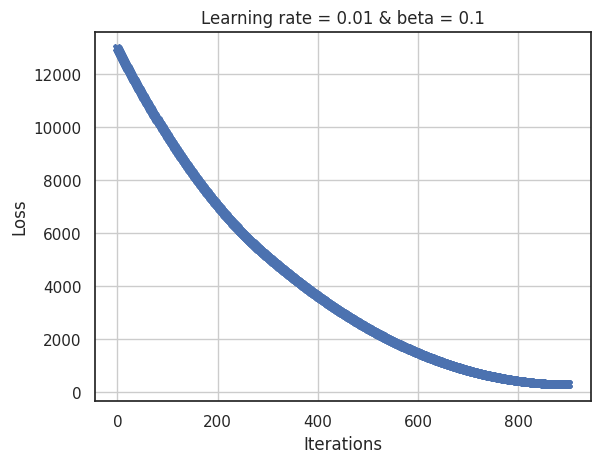

In [22]:
RMS.plot_iterations()

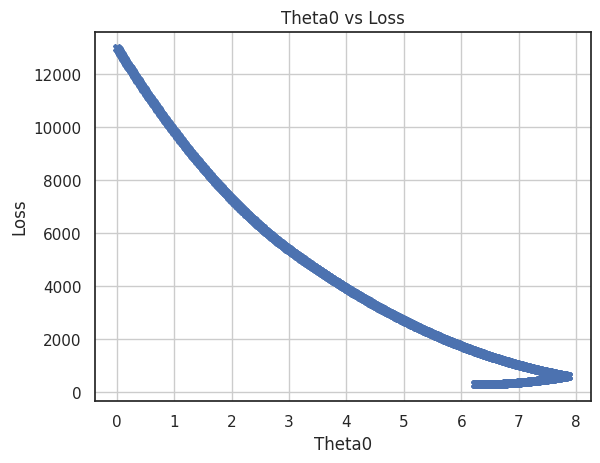

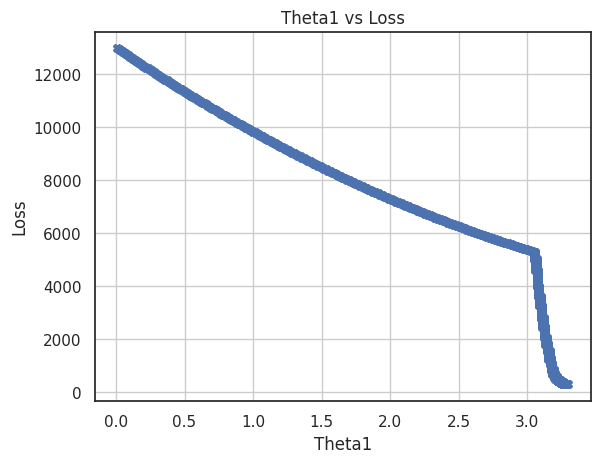

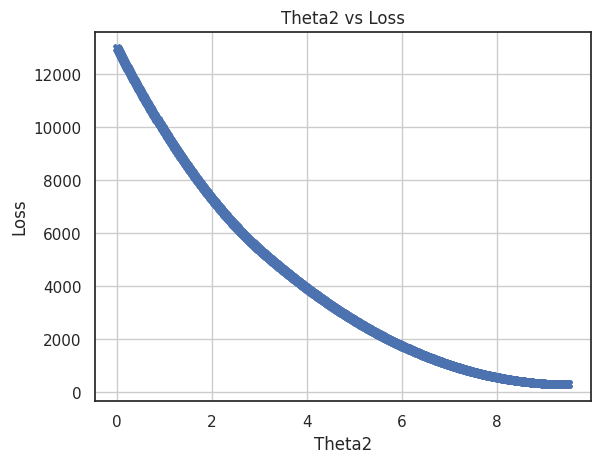

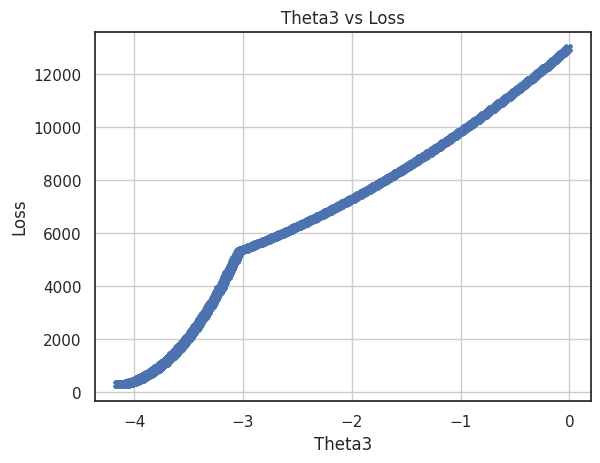

In [23]:
RMS.plot_thetas()

# **Second Order Optimizer**

## BFGS


- The update step is:
  - $$x^{(k+1)} = x^{(k)} - H(x^{(k)})^{-1} \nabla f(x^{(k)}) $$
  where $$H(x^{(k)})^{-1}$$ is estimated using:

  - $$ B_{+}^{-1} = \left(I - \frac{\Delta x y^{T}}{y^{T} \Delta x}\right) B^{-1} \left(I - \frac{y \Delta x^{T}}{y^{T} \Delta x}\right) + \frac{\Delta x \Delta x^{T}}{y^{T} \Delta x} $$



In [24]:
def Quasi_Newton_Raphson_multivariable (input_data,target_variable,Learning_rate, max_iterations,gradient_tolerance,cost_tolerance):
    ones = np.ones(shape=(len(target_variable), 1))
    input_data = np.append(ones, input_data, axis=1)
    I=np.identity(np.shape(input_data)[1])
    B=np.identity(np.shape(input_data)[1])
    thetas1 = np.zeros(shape=(np.shape(input_data)[1], 1))
    thetas=np.ones(shape=np.shape(input_data)[1])
    thetas=thetas.reshape((-1,1))
    Cost_arr2 = np.array([])
    J_temp=float('inf')
    Cost_arr2 = np.append(Cost_arr2, [J_temp])

    theta_history = np.array([])
    theta_history = np.append(theta_history, thetas1.flatten())
    i = 0
    while True:
        h_x = input_data @ thetas
        Error_vector = h_x - target_variable
        J = (1 / (2 * len(input_data))) * (np.linalg.norm(Error_vector, 2)) ** 2

        h_x1 = input_data @ thetas1
        Error_vector1 = h_x1 - target_variable
        delta_theta=thetas-thetas1
        delta_theta=delta_theta.reshape(-1,1)
        Gradient_vector = np.array((1 / len(input_data)) * (input_data.T @ Error_vector))
        Gradient_vector1 = np.array((1 / len(input_data)) * (input_data.T @ Error_vector1))
        y=Gradient_vector-Gradient_vector1
        y=y.reshape(-1,1)
        gradient_norm=np.linalg.norm(Gradient_vector)
        Cost_arr2 = np.append(Cost_arr2, [J])
        theta_history = np.append(theta_history, thetas.flatten())

        first=(I-((delta_theta@y.T)*(1/(y.T@delta_theta))))
        second=(I-((y@delta_theta.T)*(1/(y.T@delta_theta))))
        third=(delta_theta@delta_theta.T)*(1/(y.T@delta_theta))

        B_inv=first@B@second+third
        B=B_inv


        if gradient_norm<gradient_tolerance or  i > max_iterations or abs(Cost_arr2[-2]-Cost_arr2[-1])<cost_tolerance :
            print("Result after", i, "iterations:", thetas,'\n'*2,'gradient norm = ',gradient_norm,'\n'*2,"gradient= ",Gradient_vector1,'With cost of ',J)

            break
        thetas1=thetas
        thetas=thetas1-Learning_rate*B_inv@Gradient_vector1
        i += 1
    num_thetas = np.shape(input_data)[1]
    theta_history = theta_history.reshape((-1, num_thetas))
    theta_history=theta_history[2:,:]

    Cost_arr2 = Cost_arr2.reshape((-1, 1))
    Cost_arr2 = Cost_arr2[2:, 0]

    return thetas,Cost_arr2,theta_history,h_x

In [25]:
thetas,Cost_arr2,theta_history,h_x=Quasi_Newton_Raphson_multivariable(X,y,0.01,1000,0.001,0.001)

Result after 632 iterations: [[-2.15399254]
 [ 3.40454608]
 [ 9.6882055 ]
 [-4.07740301]] 

 gradient norm =  4.90536646318695 

 gradient=  [[ 0.01560244]
 [-0.38848311]
 [ 2.75241001]
 [-4.10235636]] With cost of  253.45848852071424


In [26]:
r2_score(y,h_x)

0.9790275853213436

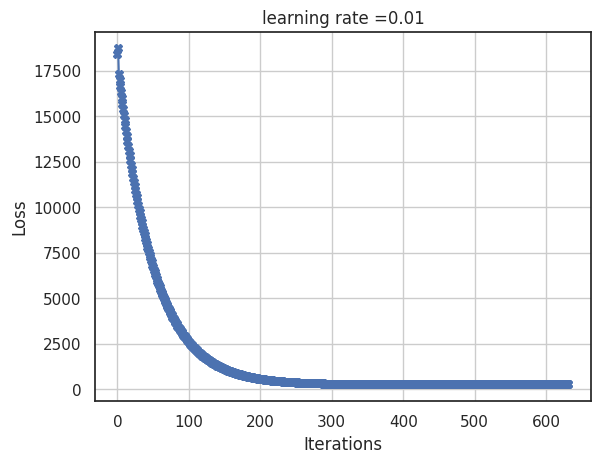

In [27]:
sns.set(style="white")
plt.plot(Cost_arr2,marker="X")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title('learning rate =0.01')
plt.grid()

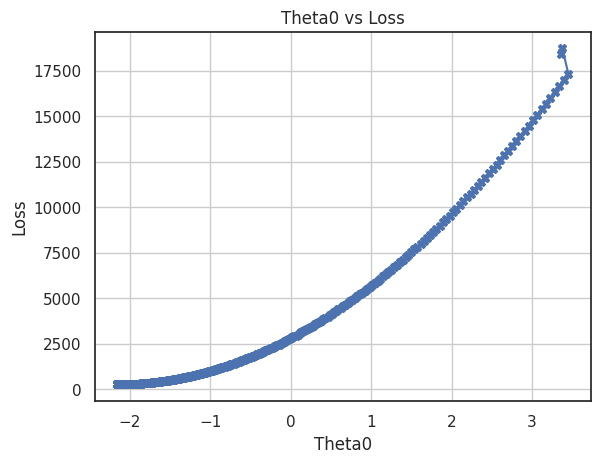

In [28]:
sns.set(style="white")
plt.plot(theta_history[:,0],Cost_arr2,marker="X")
plt.xlabel("Theta0")
plt.ylabel("Loss")
plt.grid()
plt.title("Theta0 vs Loss")
plt.show();

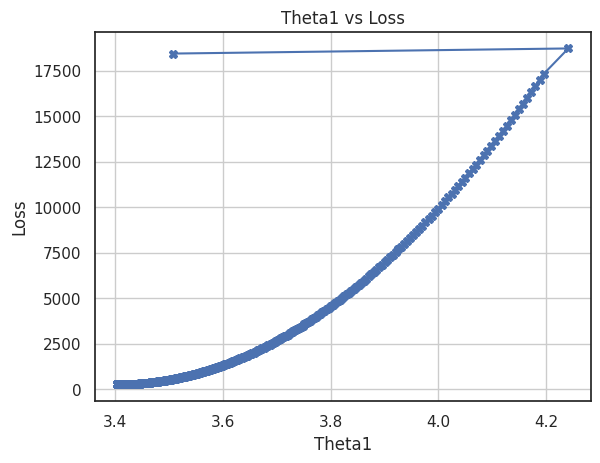

In [29]:
sns.set(style="white")
plt.plot(theta_history[:,1],Cost_arr2,marker="X")
plt.xlabel("Theta1")
plt.ylabel("Loss")
plt.grid()
plt.title("Theta1 vs Loss")
plt.show();

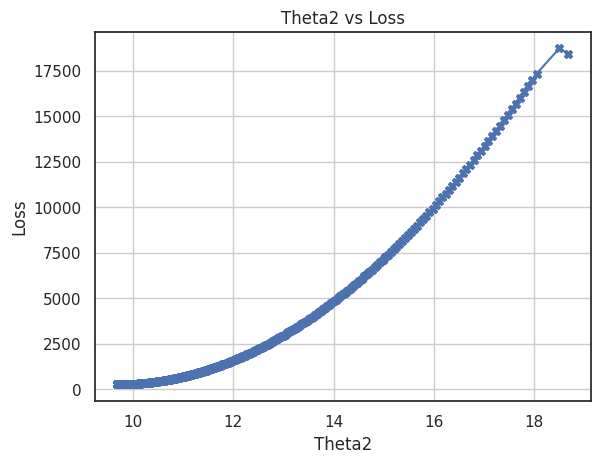

In [30]:
sns.set(style="white")
plt.plot(theta_history[:,2],Cost_arr2,marker="X")
plt.xlabel("Theta2")
plt.ylabel("Loss")
plt.grid()
plt.title("Theta2 vs Loss")
plt.show();

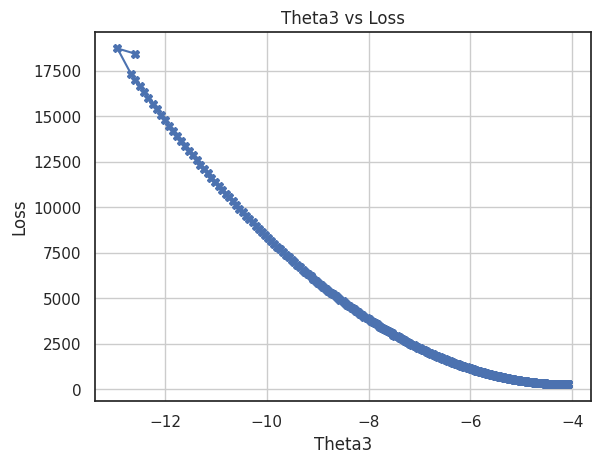

In [31]:
sns.set(style="white")
plt.plot(theta_history[:,3],Cost_arr2,marker="X")
plt.xlabel("Theta3")
plt.ylabel("Loss")
plt.grid()
plt.title("Theta3 vs Loss")
plt.show();